In [2]:

from disassembly.simulate_proteolysis_regex import ProteolysisSimulator, Enzyme

ps = ProteolysisSimulator()
hbb = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
pr39 = "METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR"
thrb = "MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE"
actb = "MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF"
calm2 = "MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTEAELQDMINEVDADGNGTIDFPEFLTMMARKMKDTDSEEEIREAFRVFDKDGNGYISAAELRHVMTNLGEKLTDEEVDEMIREADIDGDGQVNYEEFVQMMTAK"

trypsin_regex = Enzyme("trypsin", [("(.)(.)([R|K])([^P])(.)(.)", 1)])
random_regex = Enzyme("random", [("(.)(.)(.)(.)(.)(.)", 1)])
chymotrp_regex = Enzyme("chymotrypsin", [("(.)(.)([F|Y|W|M])([^P])(.)(.)(.)", 1)])
elastase_regex = Enzyme("elastase", [("(.)(.)([V|I|A|S|L|G])(.)(.)(.)", 1)])

protein_sequences = []
true_distributions = []
for seq in [actb, hbb, pr39, thrb]:
    true_distribution = ps.simulate_proteolysis(
        seq, enzyme=trypsin_regex, n_generate=500, graph=False
    )
    protein_sequences.append(seq)
    true_distributions.append(true_distribution)

 499 / 500 (591)
138 unique peptides. 510 total
 498 / 500 (514)
90 unique peptides. 510 total
 499 / 500 (590)
107 unique peptides. 510 total
 499 / 500 (697)
162 unique peptides. 510 total


In [3]:
generated_peptidomes = {"name": [], "peptidome": []}

names = ["s-trypsin", "s-chymotrypsin", "s-elastase", "random"]

ps = ProteolysisSimulator(verbose=False)

for enz, name in zip(
    [trypsin_regex, chymotrp_regex, elastase_regex, random_regex], names
):
    print(name)
    for i in range(10):
        print(f"\r{i}", end="", flush=True)
        generated_peptidome = ps.simulate_proteolysis(
            calm2,
            n_start=10,
            n_generate=500,
            enzyme=enz,
            graph=False,
        )
        generated_peptidomes["name"].append(f"{name}_{i}")
        generated_peptidomes["peptidome"].append(generated_peptidome)

s-trypsin
9s-chymotrypsin
9s-elastase
9random
9

In [4]:
from disassembly.util import KL, abs_err
from disassembly.estimate_parameters import compare

comparisons = {}
comparisons_asym = {}
comparisons_abs_err = {}
for i in range(len(generated_peptidomes["peptidome"])):
    name_comp_1 = generated_peptidomes["name"][i]
    peptidome_comp_1 = generated_peptidomes["peptidome"][i]
    comparisons[name_comp_1] = {}
    comparisons_asym[name_comp_1] = {}
    comparisons_abs_err[name_comp_1] = {}
    for j in range(len(generated_peptidomes["peptidome"])):
        name_comp_2 = generated_peptidomes["name"][j]
        peptidome_comp_2 = generated_peptidomes["peptidome"][j]
        p, q = compare(peptidome_comp_1, peptidome_comp_2)
        kl_sym = KL(p, q) + KL(q, p)
        kl_asym = KL(p,q)
        comparisons_asym[name_comp_1][name_comp_2] = kl_asym
        comparisons[name_comp_1][name_comp_2] = kl_sym
        comparisons_abs_err[name_comp_1][name_comp_2] = abs_err(p,q)

import pandas as pd

comps_df = pd.DataFrame(comparisons)

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


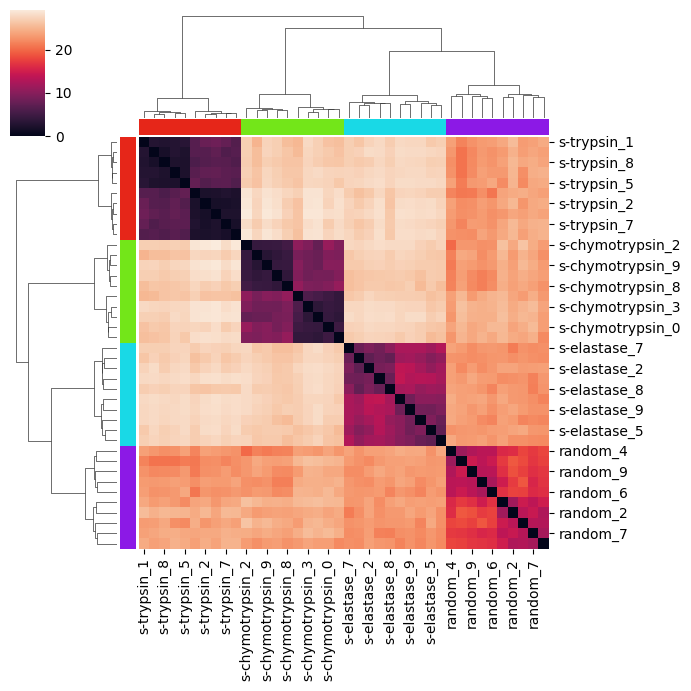

In [5]:
import seaborn as sns

lut = dict(zip(names, sns.hls_palette(len(names), l=0.5, s=0.8)))

lst = []
for i, n in enumerate(names):
    lst += [f"{n}"] * 10

row_colors = pd.DataFrame(lst)[0].map(lut)


sns.clustermap(
    comps_df,
    figsize=(7, 7),
    row_colors=row_colors.to_numpy(),
    col_colors=row_colors.to_numpy(),
)

In [6]:
from disassembly.estimate_parameters_ga import ParameterEstimatorGA

pe = ParameterEstimatorGA(
    true_distributions=true_distributions,
    protein_sequences=protein_sequences,
    mutation_rate=0.05,
    n_individuals=20,
    pattern_len=6,
    kill_fraction=0.5,
    n_generate=50,
    length_penalty=0.1,
)

parameters = pe.run(n_generations=20, temp_start=0, temp_end=2)

Computing baseline fitnesses for all protein sequences...
---
Running GA...
---
26:(.)(.)([K])(.)(.)(.) 1  0.6581819342560883
21
42:(.)(.)([K])(.)(.)(.) 1  0.3699732452257235
21
45:([W])([E])([G])(.)(.)(.) 1 (.)([K])([K])(.)(.)(.) 1 (.)(.)([K])(.)(.)(.) 1  0.8331769528650786
21
31:(.)(.)([K])(.)(.)(.) 1  0.8876093396180182
21
31:(.)(.)([K])(.)(.)(.) 1  0.6080073822217382
21
85:(.)(.)([K])(.)(.)(.) 1 (.)(.)([K|R])(.)(.)(.) 1  0.24466011847242816
21
59:(.)([^A|C])([R])(.)(.)(.) 1 (.)(.)([K])(.)(.)(.) 1 ([T])(.)([L])(.)(.)(.) 1  0.4577580303816197
21
91:(.)([A])([R])(.)(.)([S]) 1 ([L])(.)([K])(.)(.)(.) 1 (.)(.)([K])(.)(.)(.) 1 (.)(.)([K|R])(.)(.)(.) 1 (.)([P])([K])(.)(.)(.) 1  0.6805064539003263
21
114:(.)([A])([R])(.)(.)([S]) 1 (.)(.)([K])(.)(.)(.) 1 (.)(.)([K|R])(.)(.)(.) 1  0.4919408496037652
21
105:(.)(.)([K])(.)(.)(.) 1 (.)(.)([K|R])(.)([^I])(.) 1  0.21875498884093045
21
141:(.)(.)([K])(.)(.)(.) 1 (.)(.)([K|R])(.)(.)(.) 2  0.46303567498130827
21
151:(.)(.)([K])(.)(.)(.) 2 (.)(.)([K|R

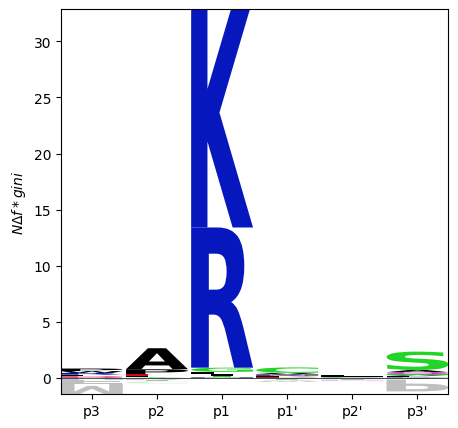

In [7]:
pe.plot(topn=100)

<Axes: xlabel='level_0', ylabel='0'>

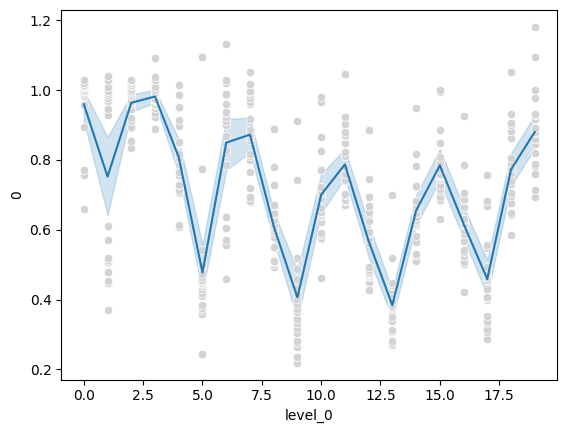

In [8]:
import pandas as pd
import seaborn as sns

sns.lineplot(pd.DataFrame(pe.fitness).T.stack().reset_index(), x="level_0", y=0)
sns.scatterplot(
    pd.DataFrame(pe.fitness).T.stack().reset_index(),
    x="level_0",
    y=0,
    color="lightgray",
)

<Axes: >

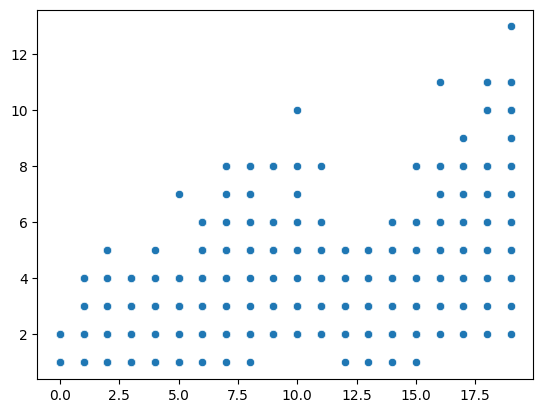

In [9]:
id_len = [(x[0], len(x[1].rules)) for x in pe.all_results.keys()]
sns.scatterplot(x=[x[0] for x in id_len], y=[x[1] for x in id_len])

In [10]:
top_population = {
            k: v for k, v in sorted(pe.all_results.items(), key=lambda item: item[1])
        }
print(list(top_population.keys())[0][1].rules)
guess_enzyme = Enzyme("guess", list(top_population.keys())[0][1].rules)
for i in range(10):
    generated_peptidome = ps.simulate_proteolysis(calm2, guess_enzyme, n_start=10, n_generate=500, graph=False)
    generated_peptidomes["name"].append(f"s-chymotrp-guess-{i}")
    generated_peptidomes["peptidome"].append(generated_peptidome)
    

[('(.)(.)([K])(.)(.)([^F])', 1), ('(.)(.)([K|R])(.)(.)(.)', 2)]


# Check if simulated proteolysis has a reasonable distance


In [11]:
import pandas as pd


df = pd.read_csv("../data/enzymes/processed.csv")
df = df[df["Protein Accession"] == "CALM2"]
df.set_index(["Peptide", "Protein Accession"], inplace=True)

pre_df = {}

for name, peptidome in zip(
    generated_peptidomes["name"], generated_peptidomes["peptidome"]
):
    pre_df[name] = peptidome
df_simulated = pd.DataFrame(pre_df)
df_simulated = df_simulated.reset_index().rename(columns={"index": "Peptide"})

merged = df.reset_index().merge(
    df_simulated, left_on="Peptide", right_on="Peptide", how="outer"
)
merged = merged.set_index("Peptide").drop(columns=["Protein Accession"])
samples = merged.columns
merged

,cht1,cht2,cht3,cht4,cht5,cht6,cht7,cht8,cht9,cht10,...,s-chymotrp-guess-0,s-chymotrp-guess-1,s-chymotrp-guess-2,s-chymotrp-guess-3,s-chymotrp-guess-4,s-chymotrp-guess-5,s-chymotrp-guess-6,s-chymotrp-guess-7,s-chymotrp-guess-8,s-chymotrp-guess-9
Peptide,,,,,,,,,,,,,,,,,,,,,
EADIDGDGQVNYEEFVQMMTAK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,7.0,2.0,NaN,NaN,1.0,5.0,NaN,2.0,3.0
EAFSLFDKDGDGTITTK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,6.0,3.0,2.0,2.0,6.0,8.0,NaN,7.0,4.0
MKDTDSEEEIREAFR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KMKDTDSEEEIREAFR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VFDKDGNGYISAAELR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,1.0,7.0,1.0,4.0,15.0,16.0,5.0,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DGNGYISAAELRHVMTNLG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
MKDTDSEEEIREAFRVFDKDGNGYISAAELR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
DTDSEEEIREAFRVFD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [12]:
data_dict = {}

for sample in samples:
    sample_data = merged[sample].dropna().reset_index()
    protein_dict = {}
    peptide_dict = {}

    for i, row in sample_data.iterrows():
        peptide = row["Peptide"]
        abundance = row[sample]
        peptide_dict[peptide] = abundance
    protein_dict[calm2] = peptide_dict
    data_dict[sample] = protein_dict
data_dict

{'cht1': {'MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTEAELQDMINEVDADGNGTIDFPEFLTMMARKMKDTDSEEEIREAFRVFDKDGNGYISAAELRHVMTNLGEKLTDEEVDEMIREADIDGDGQVNYEEFVQMMTAK': {'EADIDGDGQVNYEEFVQMMTAK': 0.0,
   'EAFSLFDKDGDGTITTK': 0.0,
   'MKDTDSEEEIREAFR': 0.0,
   'KMKDTDSEEEIREAFR': 0.0,
   'VFDKDGNGYISAAELR': 0.0,
   'IREADIDGDGQVNYEEF': 1.0,
   'MIREADIDGDGQVNYEE': 0.0,
   'SLFDKDGDGTITTK': 0.0,
   'FSLFDKDGDGTITTK': 0.0,
   'IREADIDGDGQVNYEE': 0.0,
   'ARKMKDTDSEEEIREAF': 2.0,
   'RKMKDTDSEEEIREA': 0.0,
   'MARKMKDTDSEEEIREAF': 2.0,
   'MIREADIDGDGQVNY': 0.0,
   'DKDGDGTITTKELGTVM': 1.0,
   'DTDSEEEIREAFR': 0.0,
   'MRSLGQNPTEAELQDMI': 0.0,
   'RVFDKDGNGY': 2.0,
   'MKDTDSEEEIR': 0.0,
   'DGNGYISAAELR': 0.0,
   'LFDKDGDGTITTK': 0.0,
   'FDKDGDGTITTK': 0.0,
   'KDTDSEEEIREAF': 1.0,
   'MIREADIDGDGQVNYEEF': 0.0,
   'MKDTDSEEEIREAF': 0.0,
   'FSLFDKDGDGTITT': 0.0,
   'IREADIDGDGQVNY': 0.0,
   'KMKDTDSEEEIREAF': 1.0,
   'NEVDADGNGTIDFPEFL': 0.0,
   'RSLGQNPTEAELQDMI': 0.0,
   'FDKDGDGTITTKELGTVM'

In [13]:
comparisons = {}
comparisons_asym = {}
comparisons_abs_err = {}
for i in data_dict.keys():
    if calm2 in data_dict[i].keys():
        peptidome_comp_1 = data_dict[i][calm2]
        comparisons[i] = {}
        comparisons_asym[i] = {}
        comparisons_abs_err[i] = {}
        for j in data_dict.keys():
            if calm2 in data_dict[j].keys():
                peptidome_comp_2 = data_dict[j][calm2]
                p, q = compare(peptidome_comp_1, peptidome_comp_2)

                comparisons[i][j] = KL(p, q) + KL(q, p)
                comparisons_asym[i][j] = KL(p, q)
                comparisons_abs_err[i][j] = abs_err(p,q)

In [14]:
import re

pattern1 = r"_[0-9]"
pattern2 = r"[0-9]"

groups = [re.sub(pattern2, "", re.sub(pattern1, "", s)) for s in samples]

synthetic = ["in vitro"] * 40 + ["in silico"] * 50

design = pd.DataFrame({"sample": samples, "group": groups, "synthetic": synthetic})

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


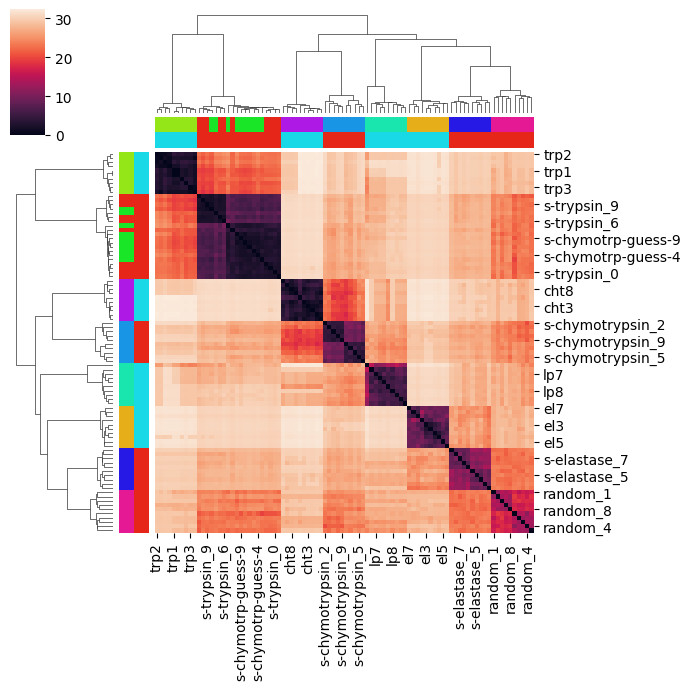

In [15]:
import seaborn as sns

labels1 = design["group"]
lut = dict(zip(set(labels1), sns.hls_palette(len(set(labels1)), l=0.5, s=0.8)))
row_colors1 = design["group"].map(lut)

labels2 = design["synthetic"]
lut = dict(zip(set(labels2), sns.hls_palette(len(set(labels2)), l=0.5, s=0.8)))
row_colors2 = design["synthetic"].map(lut)

comps_df = pd.DataFrame(comparisons)

sns.clustermap(
    comps_df,
    figsize=(7, 7),
    row_colors=[row_colors1.to_numpy(), row_colors2.to_numpy()],
    col_colors=[row_colors1.to_numpy(), row_colors2.to_numpy()],
    col_cluster=True,
    row_cluster=True,
)

In [16]:
wanted_cols = [
    col
    for col in merged.columns
    if (col.startswith("trp") or col.startswith("s-trypsin"))
]
kr_trp = merged[wanted_cols]
kr_trp

,trp1,trp2,trp3,trp4,trp5,trp6,trp7,trp8,trp9,trp10,s-trypsin_0,s-trypsin_1,s-trypsin_2,s-trypsin_3,s-trypsin_4,s-trypsin_5,s-trypsin_6,s-trypsin_7,s-trypsin_8,s-trypsin_9
Peptide,,,,,,,,,,,,,,,,,,,,
EADIDGDGQVNYEEFVQMMTAK,1.0,2.0,2.0,0.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0,3.0,6.0,7.0,2.0,4.0,2.0
EAFSLFDKDGDGTITTK,3.0,3.0,3.0,3.0,2.0,2.0,3.0,3.0,3.0,3.0,9.0,3.0,8.0,5.0,6.0,8.0,5.0,8.0,5.0,6.0
MKDTDSEEEIREAFR,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KMKDTDSEEEIREAFR,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VFDKDGNGYISAAELR,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,9.0,23.0,NaN,8.0,2.0,2.0,NaN,1.0,1.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DGNGYISAAELRHVMTNLG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MKDTDSEEEIREAFRVFDKDGNGYISAAELR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DTDSEEEIREAFRVFD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


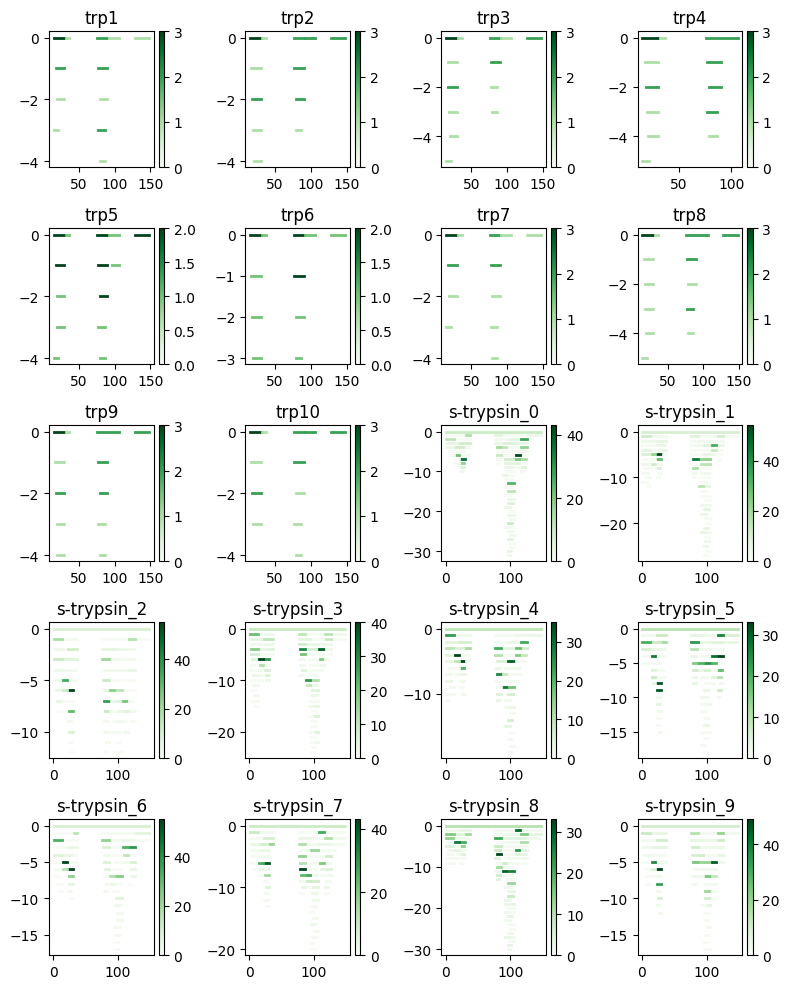

In [17]:
from disassembly.util import plot_peptidome
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(
    5,
    4,
    figsize=(8,10),
)
samples = kr_trp.columns.tolist()
for col, ax in zip(kr_trp.columns, axs.ravel()):
    d = kr_trp[col]
    i = kr_trp.columns.tolist().index(col)

    ax.set_title(f"{col}")
    d = d.replace(0, np.nan).dropna()

    plot_peptidome(
        calm2,
        d,
        ax,
    )
plt.tight_layout()

# Lets find rules for a real elastase

In [18]:
elastase_distributions = []
protein_sequences = []
for key in data_dict.keys():
    if "el" in key:
        elastase_distributions.append(data_dict[key][calm2])
        protein_sequences.append(calm2)


pe = ParameterEstimatorGA(
    true_distributions=elastase_distributions,
    protein_sequences=protein_sequences,
    mutation_rate=0.05,
    n_individuals=30,
    pattern_len=6,
    kill_fraction=0.5,
    n_generate=50,
    length_penalty=0.1,
)

parameters = pe.run(n_generations=20, temp_start=0, temp_end=2)

Computing baseline fitnesses for all protein sequences...
---
Running GA...
---
286:(.)(.)([A])(.)(.)(.) 1  0.8161141436464933
31
291:(.)(.)([A])(.)(.)(.) 1 (.)(.)([W])(.)(.)(.) 1  0.8469720334040179
31
277:(.)(.)([A])(.)(.)(.) 1 (.)(.)([W])(.)(.)(.) 1  0.8324018613560773
31
316:(.)(.)([C])(.)(.)(.) 1 (.)(.)([A])(.)(.)(.) 1 (.)(.)([W])(.)(.)(.) 1  0.7884209462160693
31
321:(.)(.)([A])(.)(.)(.) 1 (.)(.)([H])(.)(.)(.) 1  0.7736286771996614
31
355:(.)(.)([A])(.)(.)(.) 1 (.)(.)([W])([E])(.)(.) 1 (.)(.)([W])(.)(.)(.) 1 ([^T])(.)([C])(.)(.)(.) 2  0.751566009144578
31
361:(.)(.)([A])(.)(.)(.) 1 (.)(.)([W])(.)(.)(.) 1  0.7556181691570504
31
361:(.)(.)([A])(.)(.)(.) 1 (.)(.)([W])(.)(.)(.) 1  0.8225854380987087
31
410:(.)(.)([C])(.)(.)(.) 1 (.)(.)([A])(.)(.)(.) 1 (.)(.)([W])(.)(.)(.) 1 (.)(.)([A])(.)(.)([^R]) 1 (.)([^H])([W])(.)(.)(.) 1  0.8591683681751343
31
423:(.)(.)([W])(.)(.)(.) 1 (.)(.)([A])(.)(.)(.) 2 ([W])(.)(.)(.)(.)(.) 1  0.817760363656425
31
434:(.)(.)([A])(.)(.)(.) 1 ([C])(.)([A])([A

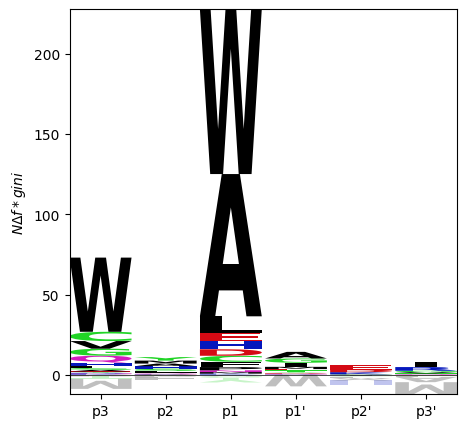

In [32]:
pe.plot(topn=10000)

<Axes: xlabel='level_0', ylabel='0'>

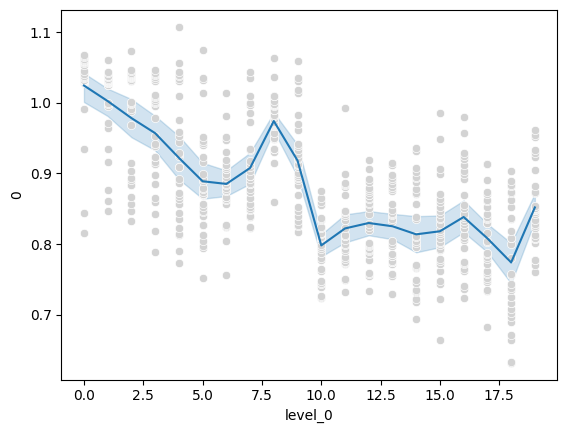

In [20]:
import pandas as pd
import seaborn as sns

sns.lineplot(pd.DataFrame(pe.fitness).T.stack().reset_index(), x="level_0", y=0)
sns.scatterplot(
    pd.DataFrame(pe.fitness).T.stack().reset_index(),
    x="level_0",
    y=0,
    color="lightgray",
)

<Axes: >

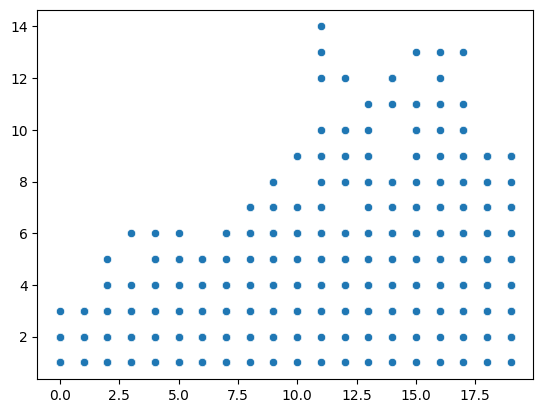

In [21]:
id_len = [(x[0], len(x[1].rules)) for x in pe.all_results.keys()]
sns.scatterplot(x=[x[0] for x in id_len], y=[x[1] for x in id_len])

In [22]:
top_population = {
            k: v for k, v in sorted(pe.all_results.items(), key=lambda item: item[1])
        }
print(list(top_population.keys())[0][1].rules)
guess_enzyme = Enzyme("real_guess", list(top_population.keys())[0][1].rules)
for i in range(10):
    generated_peptidome = ps.simulate_proteolysis(calm2, guess_enzyme, n_start=10, n_generate=500, graph=False)
    generated_peptidomes["name"].append(f"elastase-guess-{i}")
    generated_peptidomes["peptidome"].append(generated_peptidome)
    

[('([W])(.)(.)(.)(.)(.)', 2), ('(.)(.)([A])(.)(.)(.)', 3)]


In [23]:
import pandas as pd


df = pd.read_csv("../data/enzymes/processed.csv")
df = df[df["Protein Accession"] == "CALM2"]
df.set_index(["Peptide", "Protein Accession"], inplace=True)

pre_df = {}

for name, peptidome in zip(
    generated_peptidomes["name"], generated_peptidomes["peptidome"]
):
    pre_df[name] = peptidome
df_simulated = pd.DataFrame(pre_df)
df_simulated = df_simulated.reset_index().rename(columns={"index": "Peptide"})

merged = df.reset_index().merge(
    df_simulated, left_on="Peptide", right_on="Peptide", how="outer"
)
merged = merged.set_index("Peptide").drop(columns=["Protein Accession"])
samples = merged.columns
merged

,cht1,cht2,cht3,cht4,cht5,cht6,cht7,cht8,cht9,cht10,...,elastase-guess-0,elastase-guess-1,elastase-guess-2,elastase-guess-3,elastase-guess-4,elastase-guess-5,elastase-guess-6,elastase-guess-7,elastase-guess-8,elastase-guess-9
Peptide,,,,,,,,,,,,,,,,,,,,,
EADIDGDGQVNYEEFVQMMTAK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EAFSLFDKDGDGTITTK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MKDTDSEEEIREAFR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KMKDTDSEEEIREAFR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VFDKDGNGYISAAELR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TNLGEKLTDEEVDEMIREADIDGDGQVNYEEFVQMMTAK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
VDEMIREA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
AELRHVMTNLGEKLTDEEVD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [24]:
data_dict = {}

for sample in samples:
    sample_data = merged[sample].dropna().reset_index()
    protein_dict = {}
    peptide_dict = {}

    for i, row in sample_data.iterrows():
        peptide = row["Peptide"]
        abundance = row[sample]
        peptide_dict[peptide] = abundance
    protein_dict[calm2] = peptide_dict
    data_dict[sample] = protein_dict
data_dict

{'cht1': {'MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTEAELQDMINEVDADGNGTIDFPEFLTMMARKMKDTDSEEEIREAFRVFDKDGNGYISAAELRHVMTNLGEKLTDEEVDEMIREADIDGDGQVNYEEFVQMMTAK': {'EADIDGDGQVNYEEFVQMMTAK': 0.0,
   'EAFSLFDKDGDGTITTK': 0.0,
   'MKDTDSEEEIREAFR': 0.0,
   'KMKDTDSEEEIREAFR': 0.0,
   'VFDKDGNGYISAAELR': 0.0,
   'IREADIDGDGQVNYEEF': 1.0,
   'MIREADIDGDGQVNYEE': 0.0,
   'SLFDKDGDGTITTK': 0.0,
   'FSLFDKDGDGTITTK': 0.0,
   'IREADIDGDGQVNYEE': 0.0,
   'ARKMKDTDSEEEIREAF': 2.0,
   'RKMKDTDSEEEIREA': 0.0,
   'MARKMKDTDSEEEIREAF': 2.0,
   'MIREADIDGDGQVNY': 0.0,
   'DKDGDGTITTKELGTVM': 1.0,
   'DTDSEEEIREAFR': 0.0,
   'MRSLGQNPTEAELQDMI': 0.0,
   'RVFDKDGNGY': 2.0,
   'MKDTDSEEEIR': 0.0,
   'DGNGYISAAELR': 0.0,
   'LFDKDGDGTITTK': 0.0,
   'FDKDGDGTITTK': 0.0,
   'KDTDSEEEIREAF': 1.0,
   'MIREADIDGDGQVNYEEF': 0.0,
   'MKDTDSEEEIREAF': 0.0,
   'FSLFDKDGDGTITT': 0.0,
   'IREADIDGDGQVNY': 0.0,
   'KMKDTDSEEEIREAF': 1.0,
   'NEVDADGNGTIDFPEFL': 0.0,
   'RSLGQNPTEAELQDMI': 0.0,
   'FDKDGDGTITTKELGTVM'

In [25]:
comparisons = {}
comparisons_asym = {}
comparisons_abs_err = {}
for i in data_dict.keys():
    if calm2 in data_dict[i].keys():
        peptidome_comp_1 = data_dict[i][calm2]
        comparisons[i] = {}
        comparisons_asym[i] = {}
        comparisons_abs_err[i] = {}
        for j in data_dict.keys():
            if calm2 in data_dict[j].keys():
                peptidome_comp_2 = data_dict[j][calm2]
                p, q = compare(peptidome_comp_1, peptidome_comp_2)

                comparisons[i][j] = KL(p, q) + KL(q, p)
                comparisons_asym[i][j] = KL(p, q)
                comparisons_abs_err[i][j] = abs_err(p,q)

In [26]:
import re

pattern1 = r"_[0-9]"
pattern2 = r"[0-9]"

groups = [re.sub(pattern2, "", re.sub(pattern1, "", s)) for s in samples]

synthetic = ["in vitro"] * 40 + ["in silico"] * 60

design = pd.DataFrame({"sample": samples, "group": groups, "synthetic": synthetic})

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, me

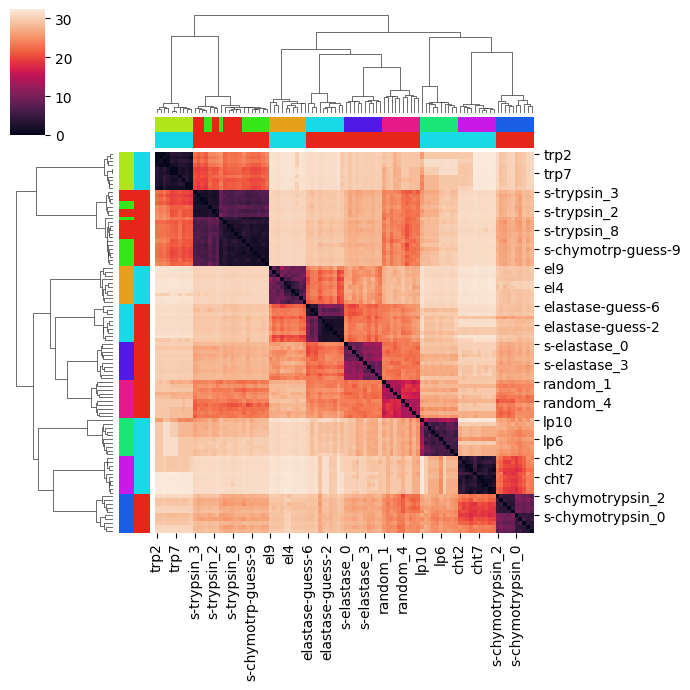

In [27]:
labels1 = design["group"]
lut = dict(zip(set(labels1), sns.hls_palette(len(set(labels1)), l=0.5, s=0.8)))
row_colors1 = design["group"].map(lut)

labels2 = design["synthetic"]
lut = dict(zip(set(labels2), sns.hls_palette(len(set(labels2)), l=0.5, s=0.8)))
row_colors2 = design["synthetic"].map(lut)

comps_df = pd.DataFrame(comparisons)

sns.clustermap(
    comps_df,
    figsize=(7, 7),
    row_colors=[row_colors1.to_numpy(), row_colors2.to_numpy()],
    col_colors=[row_colors1.to_numpy(), row_colors2.to_numpy()],
    col_cluster=True,
    row_cluster=True,
)